In [23]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

In [24]:
# target = "target_close"
target = "close_percent_change_1"
# target = "up_down_close_1"

In [25]:
# Load model
# model = pickle.load(open("../model/xgboost_model.pkl", "rb"))

try:
    model = xgb.XGBRegressor()
    model.load_model("../model/xgboost_model.json")
except:
    model = xgb.XGBClassifier()
    model.load_model("../model/xgboost_model.json")

In [26]:
# print features name
print(len(model.get_booster().feature_names))
model.get_booster().get_score()

333


{'open': 722.0,
 'high': 487.0,
 'low': 274.0,
 'close': 149.0,
 'adj close': 92.0,
 'volume': 568.0,
 'up_down_close_1': 171.0,
 'volitility_open_7': 463.0,
 'volitility_pct_change_7_open': 611.0,
 'high_low_7': 361.0,
 'high_close_7': 498.0,
 'low_close_7': 576.0,
 'true_range_7': 227.0,
 'average_true_range_7': 199.0,
 'open_rolling_mean_7': 52.0,
 'open_rolling_exp_mean_7': 27.0,
 'rsi_7': 633.0,
 'short_ema_12': 178.0,
 'long_ema_26': 119.0,
 'macd_12_26': 394.0,
 'signal_9': 276.0,
 'macd_hist_12_26_9': 408.0,
 'stochastic_oscillator_7': 464.0,
 'williams_r_7': 317.0,
 'on_balance_volume_1': 217.0,
 'volume_weighted_average_price_7': 16.0,
 'open_rolling_std_7': 151.0,
 'open_bollinger_upper_7': 25.0,
 'open_bollinger_lower_7': 24.0,
 'volitility_open_14': 174.0,
 'volitility_pct_change_14_open': 317.0,
 'high_low_14': 115.0,
 'high_close_14': 189.0,
 'low_close_14': 199.0,
 'true_range_14': 95.0,
 'average_true_range_14': 110.0,
 'open_rolling_mean_14': 10.0,
 'open_rolling_exp_

In [27]:
# load predictions
df = pd.read_parquet("../data/predicted.parquet")

In [28]:
def normalize_column(data: pd.DataFrame, column: str | list) -> pd.DataFrame:
    if isinstance(column, str):
        data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    elif isinstance(column, list):
        for col in column:
            data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    return data

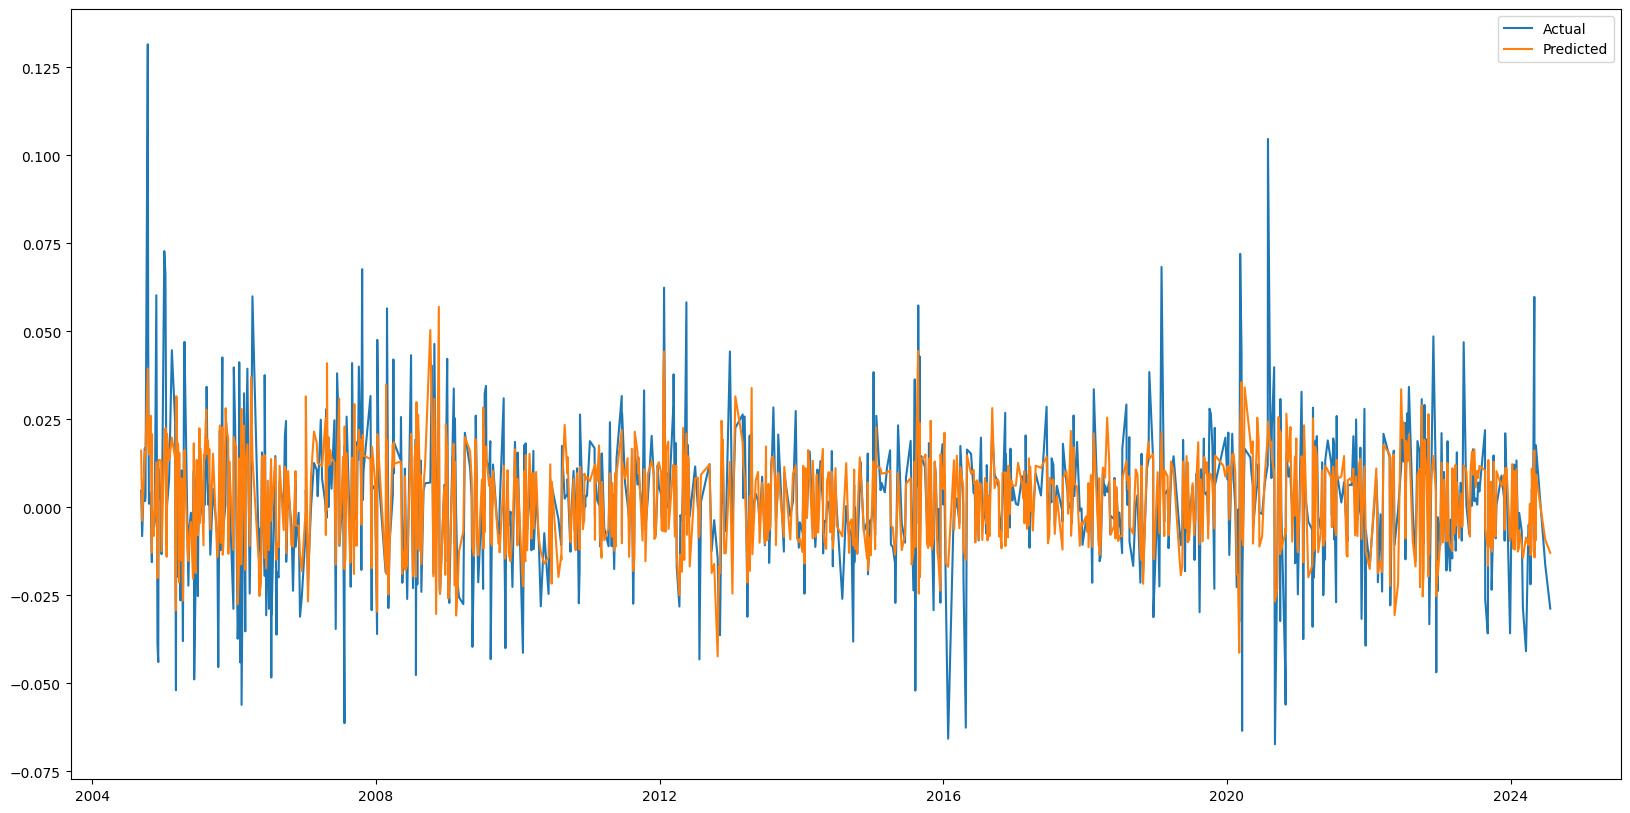

In [29]:
# Plot the predicted vs actual values
plt.figure(figsize=(20, 10))
plt.plot(df[target], label="Actual")
plt.plot(df["predicted"], label="Predicted")
plt.legend()
plt.show()

<Axes: xlabel='date', ylabel='value'>

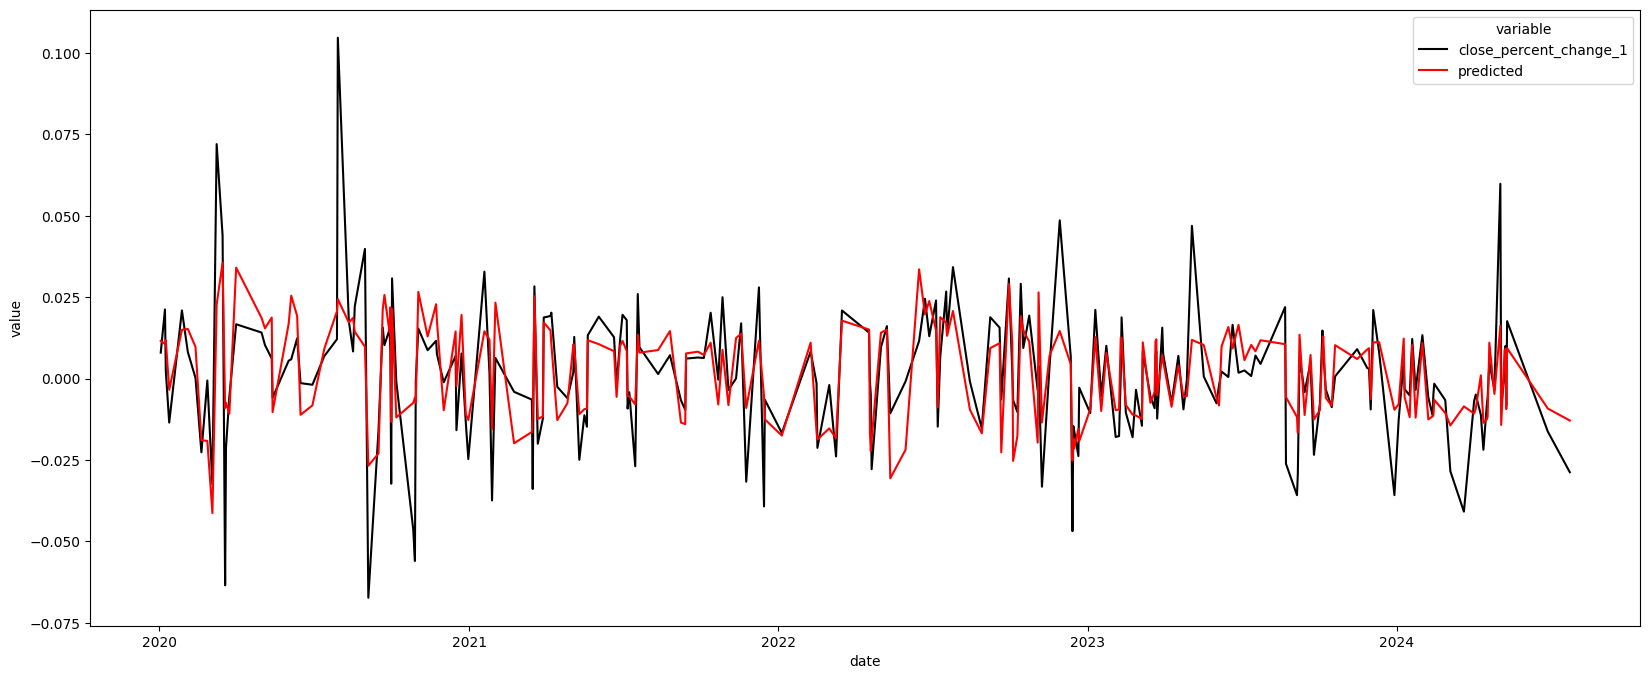

In [30]:
fig, ax = plt.subplots(figsize=(20, 8))
# Only 2008 - 2012 indexs 
df_date = df.loc["2020":"2024"]

sns.lineplot(
    df_date.reset_index().melt(id_vars=["date"], value_vars=[target, "predicted"]),
    y="value",
    x="date",
    hue="variable",
    linewidth=1.5,
    palette=['black', 'red'],
    ax=ax,
)

In [31]:
df_importance = pd.DataFrame()

importance_types = ["weight", "gain", "cover", "total_gain", "total_cover"]
for importance_type in importance_types:
    importance = model.get_booster().get_score(importance_type=importance_type)

    df_i = pd.DataFrame(importance.items(), columns=["feature", importance_type])

    if df_importance.empty:
        df_importance = df_i
    else:
        df_importance = pd.merge(df_importance, df_i, on="feature", how="outer")
df_importance


,feature,weight,gain,cover,total_gain,total_cover
0,adj close,92.0,0.000079,36.413044,0.007293,3350.0
1,average_true_range_14,110.0,0.000132,388.809082,0.014520,42769.0
2,average_true_range_30,114.0,0.000253,379.219299,0.028820,43231.0
3,average_true_range_7,199.0,0.000223,176.849243,0.044434,35193.0
4,close,149.0,0.000031,17.436241,0.004556,2598.0
...,...,...,...,...,...,...
311,week_of_year,267.0,0.000261,302.573029,0.069709,80787.0
312,williams_r_14,332.0,0.000359,319.379517,0.119083,106034.0
313,williams_r_30,216.0,0.000346,333.671295,0.074783,72073.0
314,williams_r_7,317.0,0.000236,351.750793,0.074827,111505.0


In [32]:
df_importance = normalize_column(df_importance, ["weight", "gain", "cover", "total_gain", "total_cover"])
df_importance_melted = df_importance.sort_values(by="weight", ascending=True).melt(id_vars=["feature"], value_vars=importance_types)
df_importance_melted

,feature,variable,value
0,high_lag_14,weight,0.000000
1,high_rolling_exp_mean_7,weight,0.000000
2,low_rolling_mean_30,weight,0.000000
3,low_rolling_mean_14,weight,0.000000
4,low_rolling_exp_mean_7,weight,0.000000
...,...,...,...
1575,low_close_7,total_cover,0.343132
1576,close_percent_change_7,total_cover,1.000000
1577,volitility_pct_change_7_open,total_cover,0.387721
1578,rsi_7,total_cover,0.667823


<Axes: xlabel='value', ylabel='feature'>

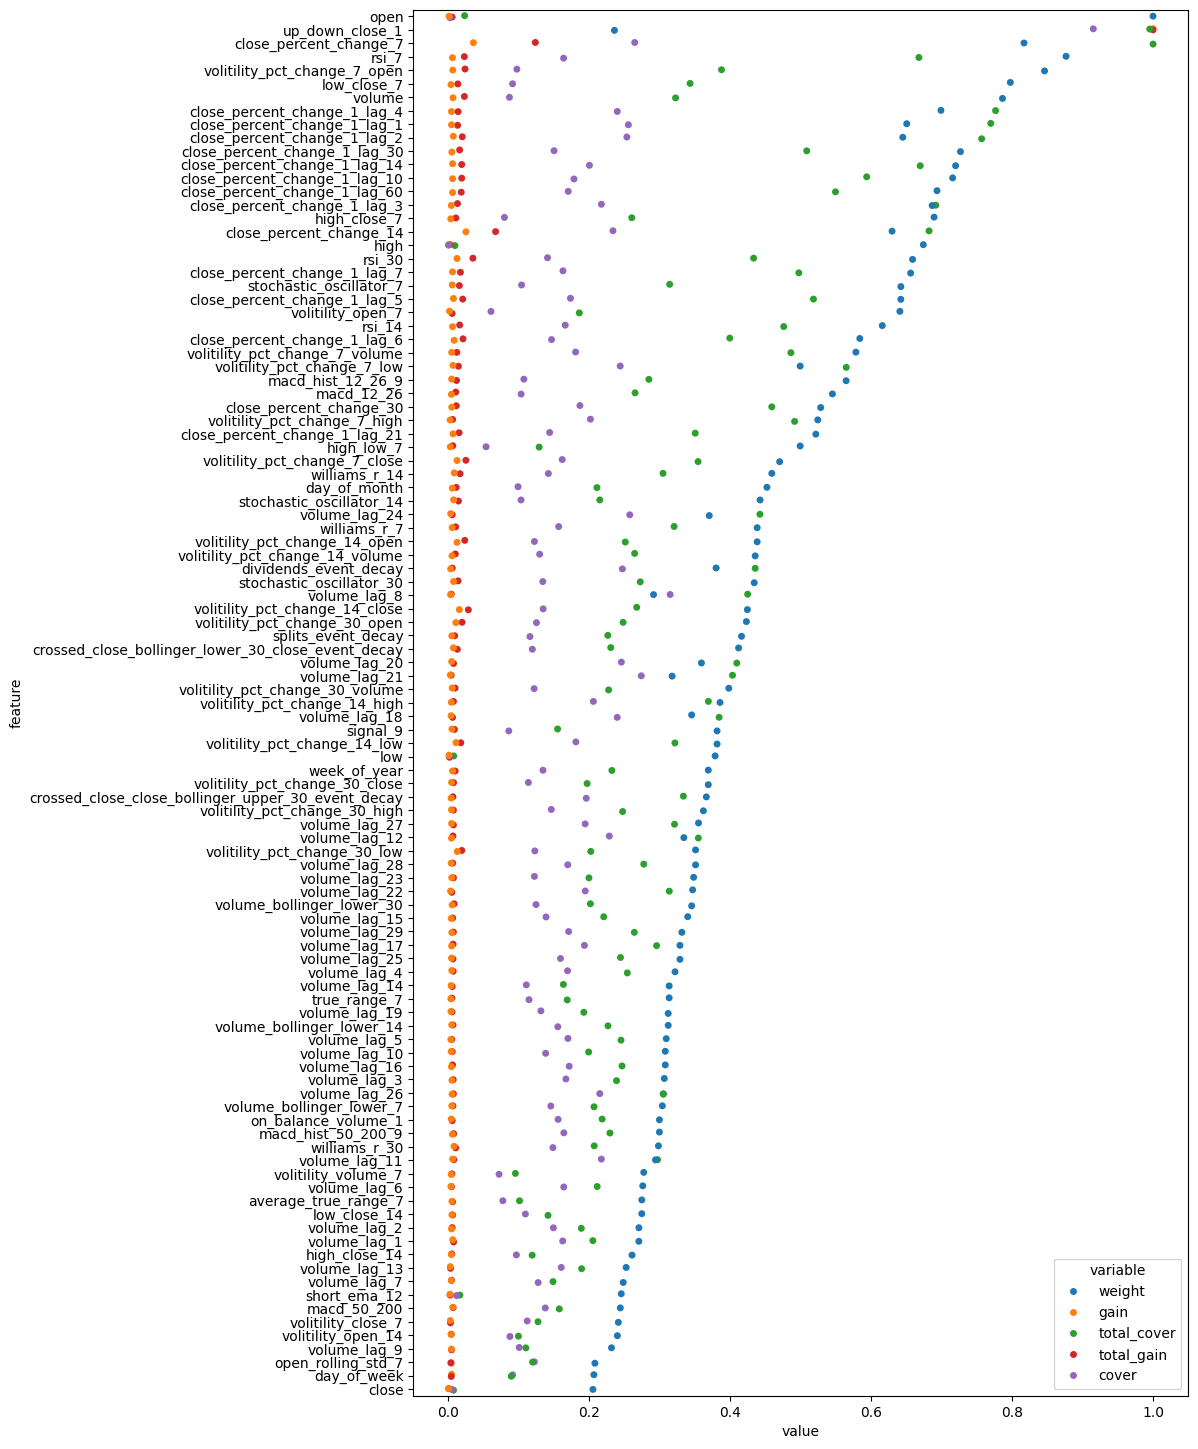

In [33]:
fig, ax = plt.subplots(figsize=(10, 18))
sns.stripplot(
    df_importance[df_importance["weight"] >= 0.2]
    .melt(id_vars=["feature"], value_vars=importance_types).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
    jitter=True,
    legend="auto",
)

<Axes: xlabel='value', ylabel='feature'>

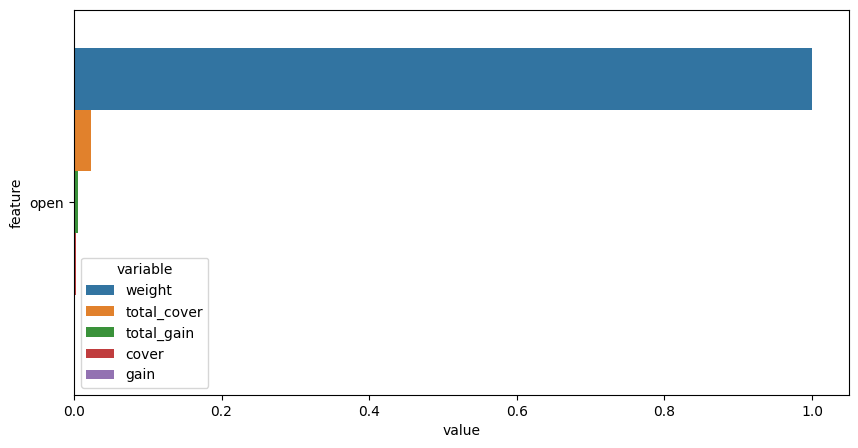

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    df_importance[df_importance["feature"] == "open"]
    .melt(id_vars=["feature"], value_vars=importance_types).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

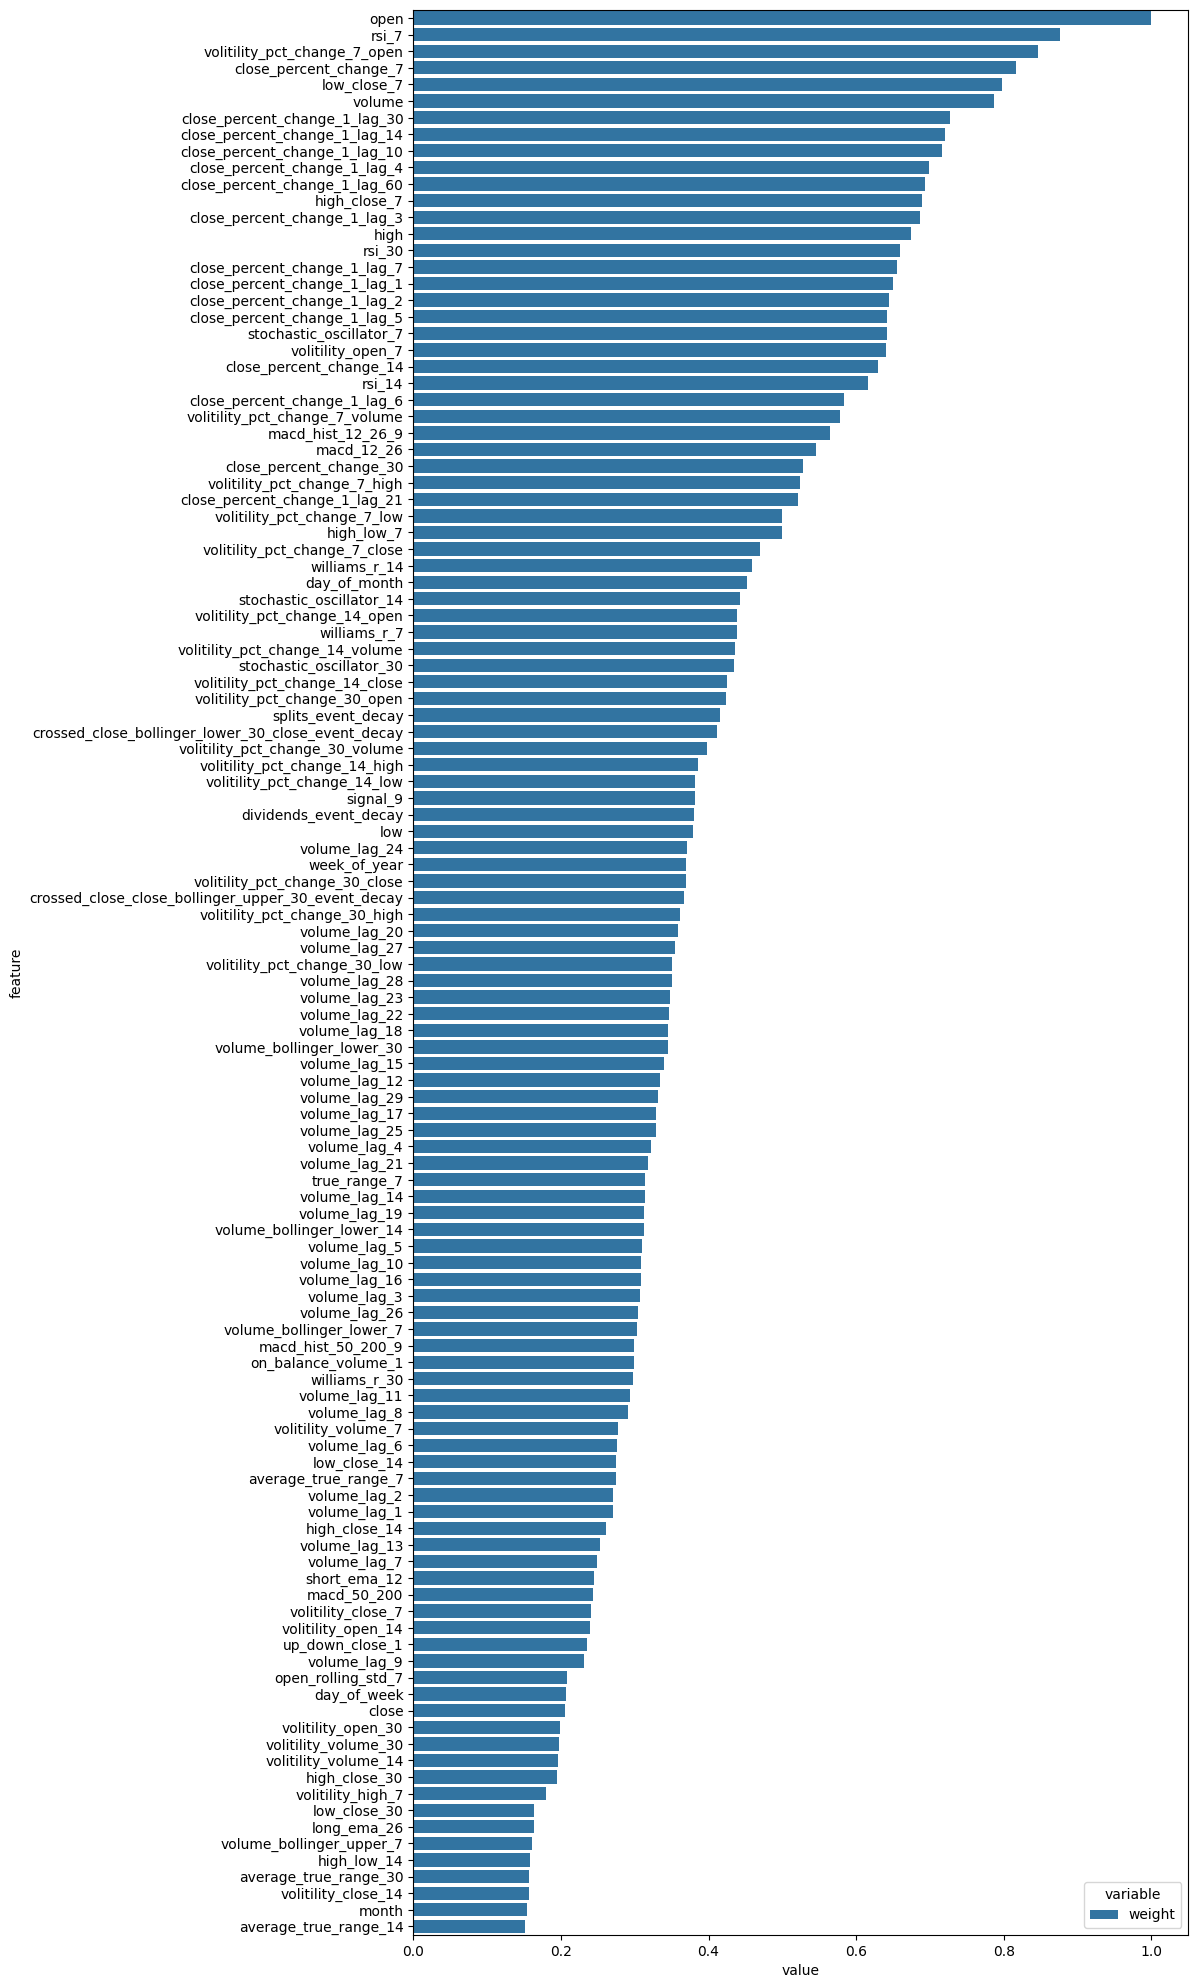

In [35]:
fig, ax = plt.subplots(figsize=(10, 25))
sns.barplot(
    df_importance[df_importance["weight"] >= 0.15][["feature", "weight"]]
    .melt(id_vars=["feature"], value_vars=["weight"]).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

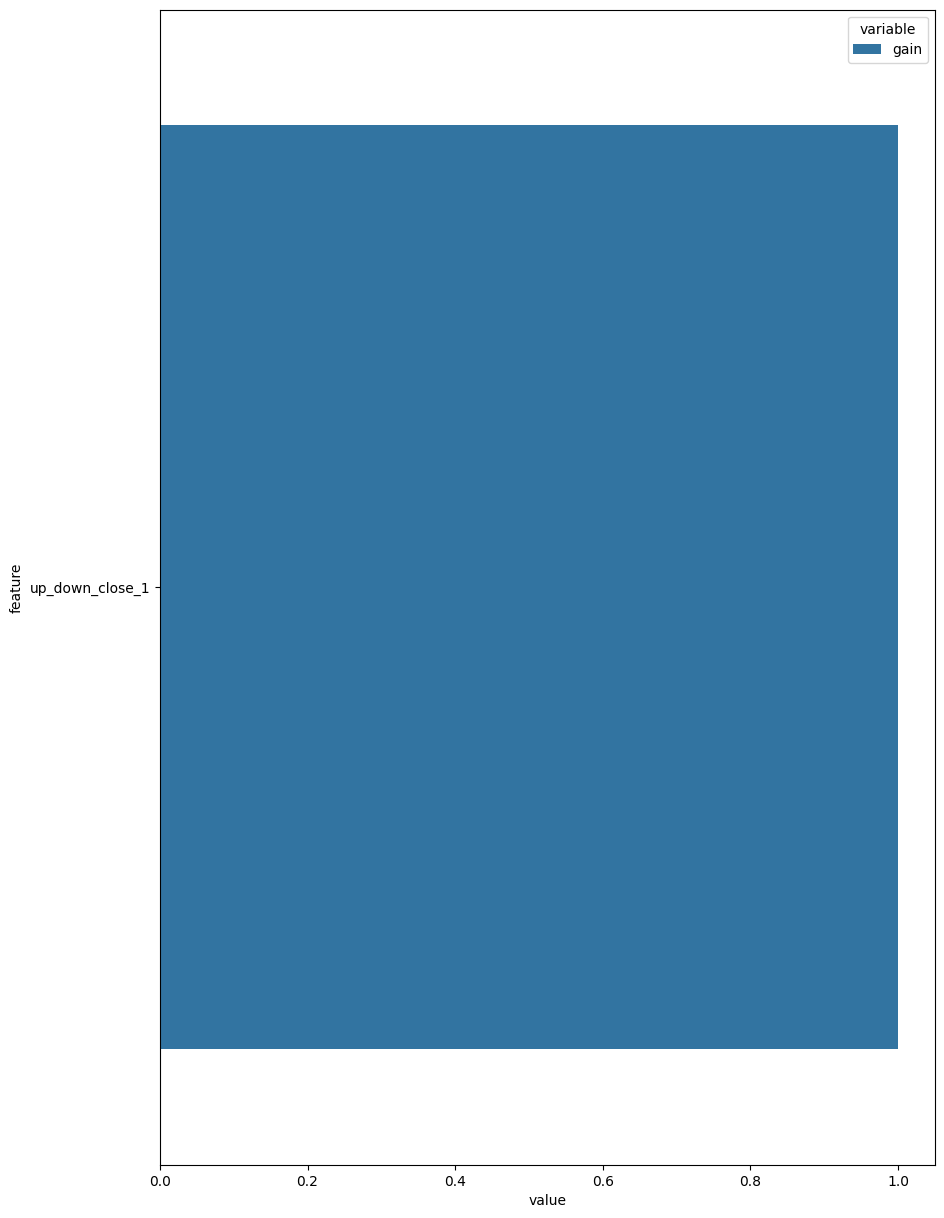

In [36]:
fig, ax = plt.subplots(figsize=(10, 15))
sns.barplot(
    df_importance[df_importance["gain"] >= 0.15][["feature", "gain"]]
    .melt(id_vars=["feature"], value_vars=["gain"]).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

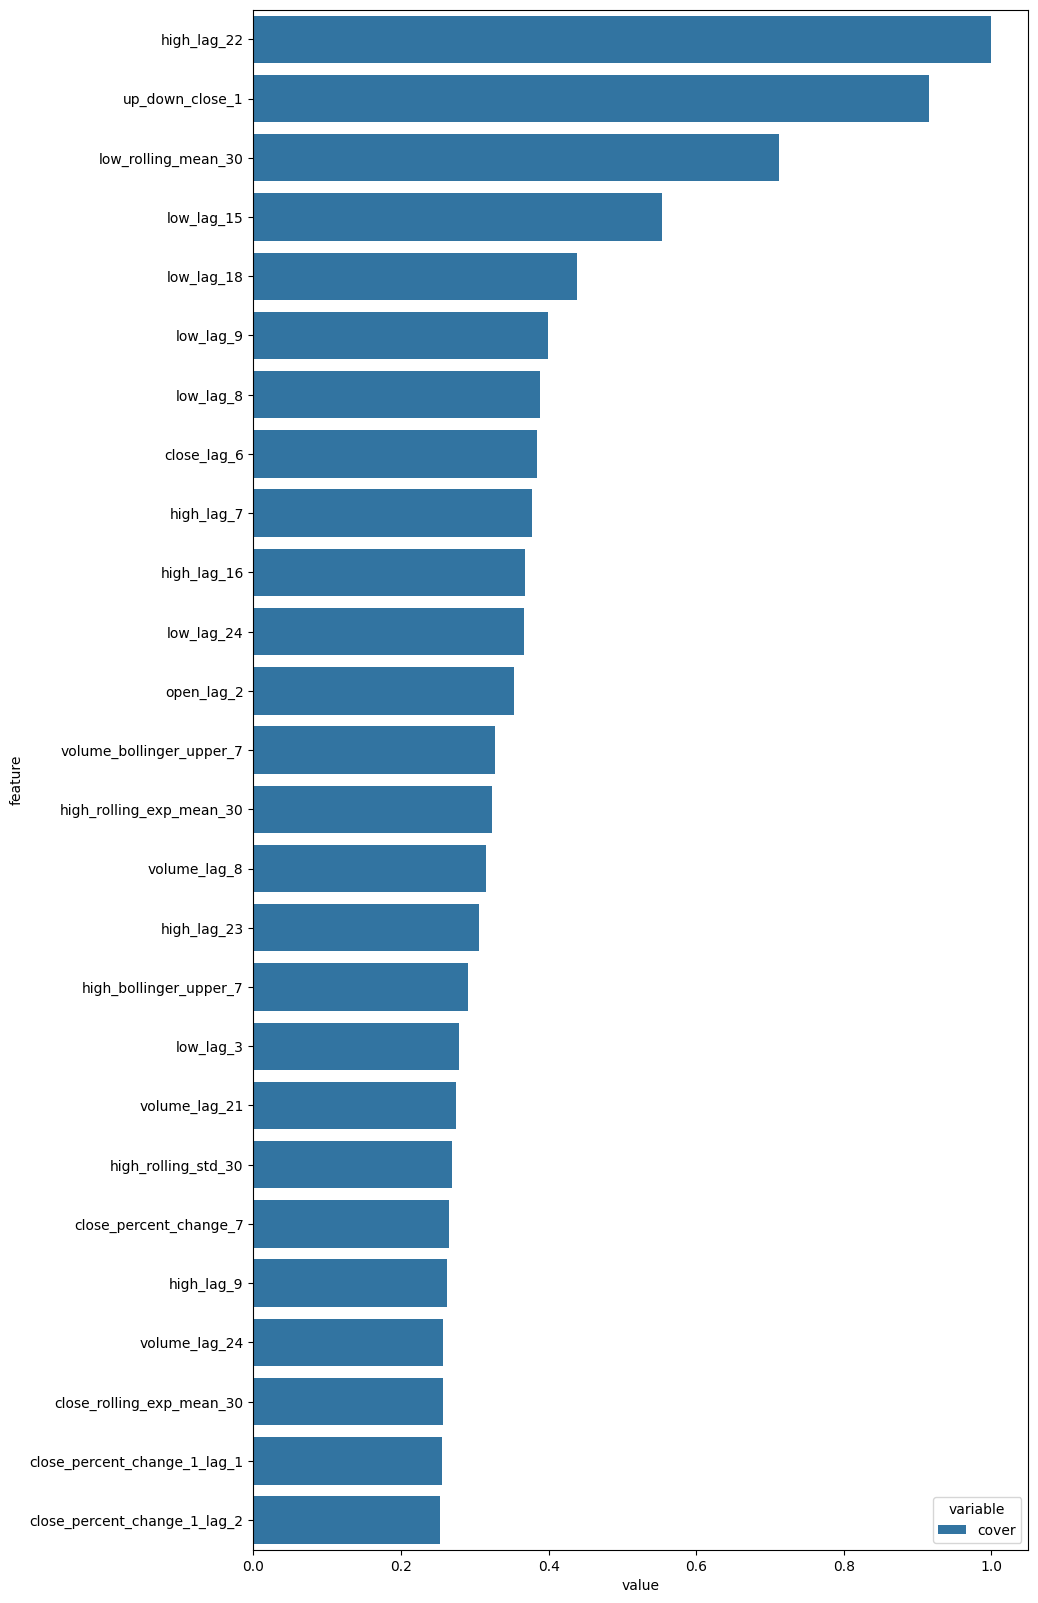

In [37]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.barplot(
    df_importance[df_importance["cover"] >= 0.25][["feature", "cover"]]
    .melt(id_vars=["feature"], value_vars=["cover"]).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)